In [15]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

import subprocess

import numpy as np
from matplotlib import pyplot as plt

import corner

from astropy import units as u
from astropy import constants as const

import fileinput

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import sys, os, glob

import time


### Toy example of SBI - SAM

 https://sbi-dev.github.io/sbi/install/

 https://astroautomata.com/blog/simulation-based-inference/

 SAM-MCMC: https://arxiv.org/pdf/0810.2548.pdf

 Absolutely read this: https://www.pnas.org/doi/full/10.1073/pnas.1912789117

Benefits over likelihod based:

- self-consistency of simulated observed data. Observed MBHF, bulge relation, LFs are often from different papers with different observational biases. Hence, the observations are not guaranteed to be self-consistent.

- speed / scalability: use deep NN to efficiently learn mapping from inputs to observations, does not suffer from increasing dimensionality adding more terms to the likelihood 

- Flexibility: Any observational quantity can be be added to the model 

Constraining black hole assembly history in semi-analytic models using simulation-based inference 

In [16]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

Priors

In [17]:
prior = utils.BoxUniform(
    low=torch.tensor([0.01, 0.01, 0.01]),
    high=torch.tensor([5.0, 5.0, 5.0]),
)

In [18]:
def stellarmassbin( sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into stellar mass bin %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logTSM <= highmass ) & \
        ( lowmass < gal.logTSM ) ) ]
    
    return gal


#### #### #### #### #### #### this is when using halo mass bins
def halomassbin( sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into halo mass bins %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logMvir <= highmass ) & ( lowmass < gal.logMvir ) ) ]
    
    return gal

### SBI Inference

In [46]:

def simulator(theta, darksagepath='/Users/colinburke/research/DarkSage', parfilename='millennium.par'):
    import os
    import glob
    import shutil
    import fileinput
    import subprocess
    import numpy as np
    import torch
    import analysis_darksage as ds

    # Temp
    import random
    i = random.randint(0, 99999999)
    print(i)

    print(theta)
    # Generate samples from N(mu, sigma=0.5)
    # Run DARK SAGE with parameters theta
    kappa_R, kappa_Q, f_BH = theta

    # Filepath to the new input directory
    parfilepath = os.path.join(darksagepath, f'input_{i}', parfilename)

    # Make new input directory
    if not os.path.exists(os.path.join(darksagepath, f'input_{i}')):
        os.makedirs(os.path.join(darksagepath, f'input_{i}'))

    # Make new output directory
    indir = os.path.join(darksagepath, f'output_{i}/')
    if not os.path.exists(indir):
        os.makedirs(indir)

    # Copy the input to a new parameter file
    print('Copying from....', os.path.join(darksagepath, f'input', parfilename))
    print('Copying to....', parfilepath)
    shutil.copy(os.path.join(darksagepath, f'input', parfilename), parfilepath)

    # Modify the new parameter file with theta
    with fileinput.input(parfilepath, inplace=True) as file:
        for line in file:
            line = line.replace('\n','')
            if 'OutputDir' in line:
                print(f'OutputDir {indir}')
            # Parameters to vary
            elif 'RadioModeEfficiency' in line:
                print(f'RadioModeEfficiency {kappa_R}')
            elif 'QuasarModeEfficiency' in line:
                print(f'QuasarModeEfficiency {kappa_Q}')
            elif 'BlackHoleGrowthRate' in line:
                print(f'BlackHoleGrowthRate {f_BH}')
            else:
                print(line)

    os.chdir(darksagepath) # Darksage can't find the extra files without this ...sigh...
    subprocess.run([f"{darksagepath}/darksage", f"{parfilepath}"])  # Run dark sage w/ theta arguments

    field = [ 'Galaxy_Classification', 'GalaxyIndex', 'HaloIndex', 'Pos', 'Vel', 
        'halospin', 'Mvir', 'Rvir', 'Vvir', 'Vmax', 'Central_Galaxy_Mvir', 
        'VelDisp', 'DiscRadii', 'Cold_Gas_Mass', 'Total_Stellar_Mass', 
        'Mergerdriven_Bulge_Mass', 'Instabilitydriven_Bulge_Mass', 'Hot_Gas_Mass', 
        'Ejected_Gas_Mass', 'Black_Hole_Mass', 'j_Stellar_Disk', 'j_Cold_Gas', 
        'SpinClassicalBulge', 'DiscStars', 'DiscHI', 'DiscH2', 'DiscSFR', 
        'SfrFromH2', 'SfrInstab', 'SfrMergeBurst', 'Disk_Scale_Radius', 
        'Cool_Scale_Radius', 'Cooling', 'Heating', 'Last_Major_Merger', 
        'Last_Minor_Merger', 'OutflowRate', 'Subhalo_Mvir_at_Infall', 
        'Subhalo_Vvir_at_Infall', 'Subhalo_Vmax_at_Infall', 'SnapNum' ]


    fpre = 'model_z0.000' # what is the prefix name of the z=0 files
    Nannuli = 30 # number of annuli used for discs in Dark Sage
    sim = 0 # which simulation Dark Sage has been run on -- if it's new, you will need to set its defaults below.
    #   0 = Mini Millennium, 1 = Full Millennium
    #range(512) # list of file numbers you want to read; 
    #change this to range(512) if sim is full Millennium merger tree or range(7) for 50 Mpc box
    files = range(8)

    if sim==0:
        h = 0.73
        Lbox = 62.5/h * (len(files)/8.)**(1./3)
    elif sim==1:
        h = 0.73
        Lbox = 500.0/h * (len(files)/512.)**(1./3)
    elif sim==2:
        h = 0.6777
        Lbox = 400.0/h * (len(files)/1000.)**(1./3)
    elif sim==3:
        h = 0.6751
        Lbox = 500.0/h * (len(files)/128.)**(1./3)
    elif sim==4:
        h = 0.6751
        Lbox = 75.0/h * (len(files)/8.)**(1./3)
    elif sim==5:
        h = 0.6777
        Lbox = 1000.0/h * (len(files)/1000.)**(1./3)


    # add here 'elif sim==4:' etc for a new simulation
    else:
        print('Please specify a valid simulation.  You may need to add its \
            defaults to this code.')
        quit()
    ######  ================= #####


    ##### READ DARK SAGE DATA #####
    data_z0DSage = ds.darksage_snap(indir+fpre, files, fields=field, Nannuli=Nannuli)
    ######  ================= #####

    #massbin = "stellarbin"                                                          # Options: "stellarbin" or "halobin" or " "
    sample = "all"                                                                  # Options: 'all' , 'centrals', 'satellites'
    #lowmassbin = 7.2                                                                # lower mass bin for either stellar mass or halo mass
    #highmassbin = 13.0                                                              # higher mass bin for either stellar mass or halo mass

    gal = ds.param_dicts( sample, data_z0DSage )

    thetahat = np.array([gal['logTSM'], gal['logBHM'], 37 + gal['logBHM']]) #.T

    thetahat = thetahat[:,:10000].ravel() # Only get first 10k galaxies and flatten

    # Delete input and output
    shutil.rmtree(os.path.join(darksagepath, f'input_{i}'))
    shutil.rmtree(indir)

    print('............................')
    print(thetahat)
    print(thetahat.shape)
    print(torch.from_numpy(thetahat).shape)
    print('............................')
    # [MBH, Ms, L] x N 
    #     
    return torch.from_numpy(thetahat)

Learn the likelihood from the simulator

In [45]:
num_sim = 200
method = 'SNRE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    # See glossary for explanation of methods.
    #    SNRE newer than SNLE newer than SNPE.
    method=method,
    num_workers=6,
    num_simulations=num_sim)

98733268
tensor([[2.6646, 0.1796, 0.0651],
        [3.8994, 4.5943, 0.3621]])
69239538
tensor([4.0457, 2.3469, 0.8006])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_69239538/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_69239538/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	      0.25
                        OmegaLambda	      0.75
                         BaryonFrac	      0.17
          

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Time: 0.634560 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.016296 s.
['/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_3', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_4', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_5', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_2', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_7', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_0', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_1', '/Users/colinburke/research/DarkSage/output_69239538/model_z0.000_6']
............................
[10.54481022 10.72719465  9.93232168 ... 40.13667714 40.13667714
 40.13667714]
(30000,)
torch.Size([30000])
............................


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

28640003
61277462
8061604448169504

88096908
93182823
tensor([2.9680, 2.4144, 4.4314])tensor([0.6387, 2.2155, 0.8382])

tensor([3.9760, 3.4636, 0.1912])
tensor([3.9480, 2.9343, 3.9023])
tensor([4.3104, 1.6203, 4.5911])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_48169504/millennium.par
tensor([0.2630, 1.6587, 0.0773])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_28640003/millennium.par
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_88096908/millennium.par
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_61277462/millennium.par
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/inp

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.636449 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.008748 s.
Time: 0.643278 s.
Time: 0.661664 s.
Time: 0.649434 s.
Time: 0.674548 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.007891 s.
Lastly, converting to log form and multiplying by 1e10s...
68353522
Time: 0.008455 s.
tensor([3.9363, 4.9984, 1.2249])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_68353522/millennium.par


NameError: name 'glob' is not defined

### Generate observed distributions

In [ ]:
def GSMF(M_star, size=1, mean=True):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01

    if mean==False:
    
        M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
        phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
        
        phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
        
        alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
        alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    else:

        M_br = 10**logM_br*u.Msun
        phi1 = phi1*u.Mpc**-3
        
        phi2 = phi2*u.Mpc**-3

    phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    return phi

In [ ]:
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

(45, 12869)


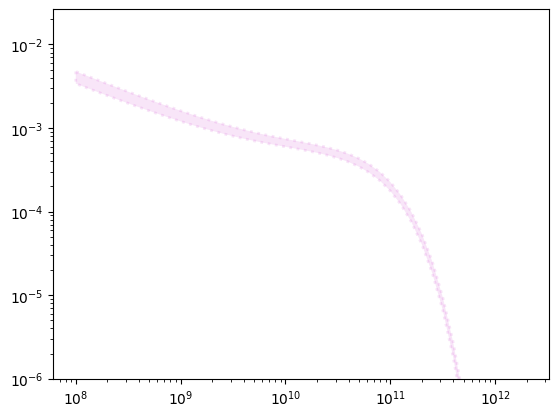

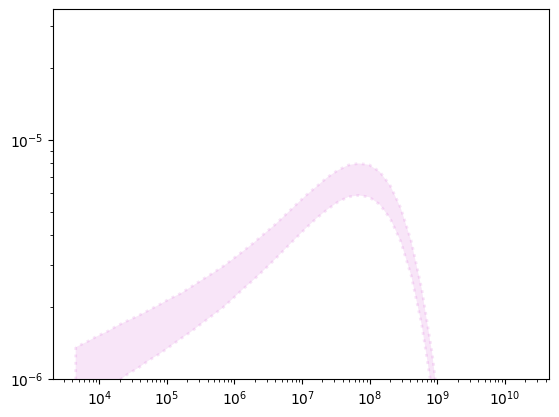

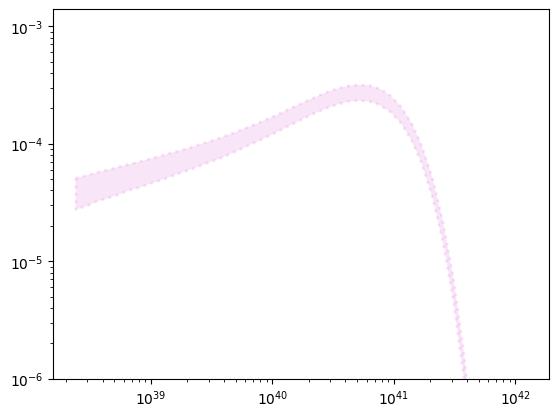

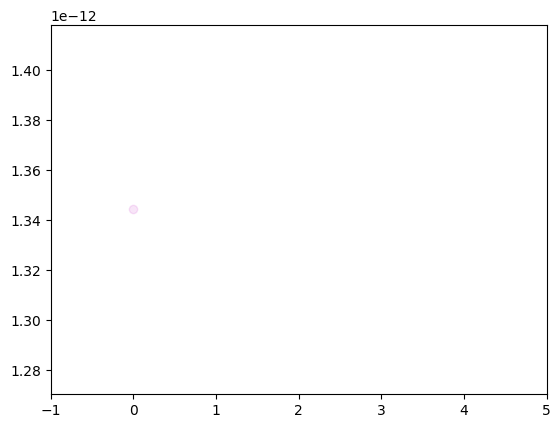

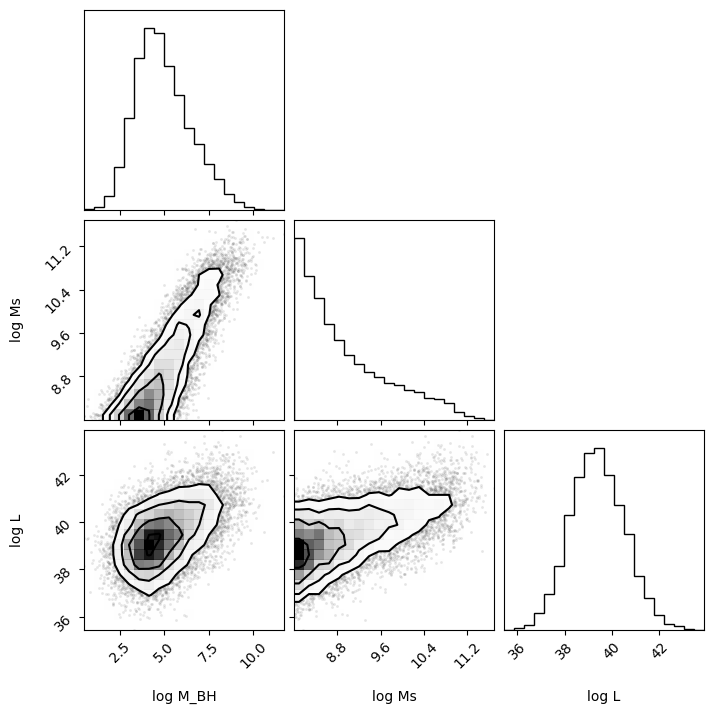

In [ ]:
dlogms =  0.1
logms = np.arange(8.0, 12.5, dlogms)
ms = 10**logms
dms = np.diff(ms, axis=0)

# TODO: use median
# Sample the "observations" from the GSMF
gsmf_mean = GSMF(ms*u.Msun, mean=True).value
omega = 4*np.pi*u.sr
V = (cosmo.comoving_volume(.01)*omega/(4*np.pi*u.sr)).to(u.Mpc**3).value
N_draw = int(V*np.trapz(gsmf_mean[:-1]*dms))

shape = [len(logms), N_draw]

# BH - stellar mass relation
# GSH20, All, limits
alpha = np.random.normal(7.43, 0.09, size=N_draw)
beta = np.random.normal(1.61, 0.12, size=N_draw)
sigma = np.random.normal(0.81, 0.06, size=N_draw)
logms0 = np.log10(3*1e10)

logmb = alpha.T + beta.T*(logms[:, np.newaxis] - logms0)
mb = 10**logmb
#_ms = np.median(ms, axis=1)
dmb = np.diff(mb, axis=0)

ms = np.ones(N_draw)*ms[:, np.newaxis]

print(ms.shape)

gsmf = GSMF(ms*u.Msun, mean=False, size=N_draw).value

plt.fill_between(ms[:-1,0], np.percentile(gsmf[:-1], 16, axis=1)*dms,
                 np.percentile(gsmf[:-1], 84, axis=1)*dms,
                color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.loglog()
plt.ylim(1e-6, None)
plt.show()

dist_stellar_mass = inv_transform_sampling(np.percentile(gsmf[:-1,:], 50, axis=1), ms[:,0], N_draw)
dist_log_stellar_mass = np.log10(dist_stellar_mass)

# Sample the "observations" from the BHMF
# Assuming occupation fraction of 1

# Plot BHMF
N = np.random.normal(loc=alpha.T + beta.T*(logms[:, np.newaxis] - logms0), scale=sigma)
bhmf_1 = (gsmf * N) 
plt.fill_between(mb[:-1,0], np.percentile(bhmf_1[:-1], 16, axis=1)*dmb[:,0],
                 np.percentile(bhmf_1[:-1], 84, axis=1)*dmb[:,0],
                 color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.loglog()
plt.ylim(1e-6, None)
plt.show()

# Sample the "observations" from the BHLF
dist_log_bh_mass = np.random.normal(loc = alpha + beta*(dist_log_stellar_mass.T - logms0), scale=sigma)

# stellar mass - L_X relation
alpha = np.random.normal(39.25, 0.2, size=shape[1])
beta = np.random.normal(0.8, 0.05, size=shape[1])
sigma = np.random.normal(0.9, 0.05, size=shape[1])
logms0 = 10

# Convolve
N = np.random.normal(loc=alpha.T + beta.T*(logms[:, np.newaxis] - logms0), scale=sigma)
logl = 1 + alpha.T + beta.T*(logms[:, np.newaxis] - logms0)
l = 10**logl
bhlf_1 = (bhmf_1 * N) 
plt.fill_between(l[:-1,0], np.percentile(bhlf_1[:-1], 16, axis=1)*dmb[:,0],
                 np.percentile(bhlf_1[:-1], 84, axis=1)*dmb[:,0],
                 color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.loglog()
plt.ylim(1e-6, None)
plt.show()

# bolometric correction of 10
dist_log_l_bol = 1 + np.random.normal(loc = alpha + beta*(dist_log_stellar_mass.T - logms0), scale=sigma)

# Convert LF to rho = |BHAR| / V
eta = 0.1
BHAR = (10**np.mean(dist_log_l_bol)*u.erg/u.s)/(eta * const.c**2)
BHAR = BHAR.to(u.Msun/u.yr)

plt.errorbar(0, (BHAR/V).value, marker='o',
                 color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.xlim(-1, 5)
plt.show()


# Plot the "observed" posterior
observation = torch.tensor([dist_log_bh_mass, dist_log_stellar_mass, dist_log_l_bol]).T
corner.corner(observation.numpy(), labels=['log M_BH', 'log Ms', 'log L']);

observation_test = np.array([dist_log_bh_mass, dist_log_stellar_mass, dist_log_l_bol])[:,:10000].ravel()


In [ ]:
observation_test # An observation of a single Universe w/ 10000 galaxies

array([ 5.83539826,  7.2086313 ,  4.33102836, ..., 40.34249477,
       40.29059594, 39.22104782])

In [ ]:
samples = posterior.sample((200,), x=observation_test)

Generating samples: 100%|██████████| 2100/2100 [02:11<00:00, 16.03it/s]


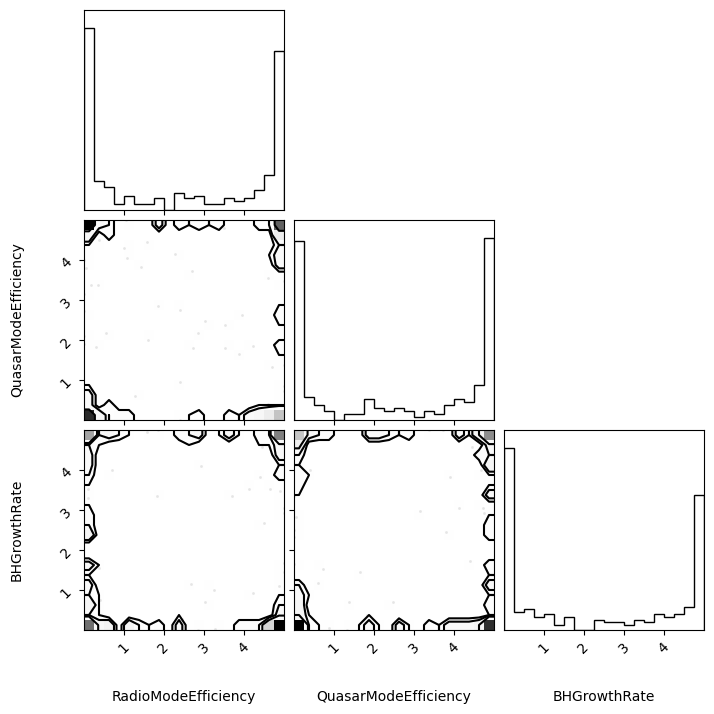

In [ ]:
log_probability = posterior.log_prob(samples, x=observation_test)
corner.corner(samples.numpy(), labels=['RadioModeEfficiency', 'QuasarModeEfficiency', 'BHGrowthRate']);

### TODO: Get the mass, luminosity distributions for the "best-fit" (calibrated) DarkSage simulation